### Topic Modelling - and more - with Gensim!

This tutorial will attempt to walk you through the entire process of analysing your text - from pre-processing to creating your topic models and visualising them. 

python offers a very rich suite of NLP and CL tools, and we will illustrate these to the best of our capabilities.
Let's start by setting up our imports.

We will be needing: 
```
- Gensim
- matplotlib
- spaCy
- pyLDAVis
```


In [1]:
import matplotlib.pyplot as plt
import gensim
import numpy as np
import spacy

from gensim.models import CoherenceModel, LdaModel, LsiModel, HdpModel
from gensim.models.wrappers import LdaMallet
from gensim.corpora import Dictionary
import pyLDAvis.gensim

import os, re, operator, warnings
warnings.filterwarnings('ignore')  # Let's not pay heed to them right now
%matplotlib inline

For this tutorial, we will be using the Lee corpus which is a shortened version of the [Lee Background Corpus](http://www.socsci.uci.edu/~mdlee/lee_pincombe_welsh_document.PDF). The shortened version consists of 300 documents selected from the Australian Broadcasting Corporation's news mail service. It consists of texts of headline stories from around the year 2000-2001. 

We should keep in mind we can use pretty much any textual data-set and go ahead with what we will be doing.

In [2]:
# since we're working in python 2.7 in this tutorial, we need to make sure to clean our data to make it unicode consistent
def clean(text):
    return unicode(''.join([i if ord(i) < 128 else ' ' for i in text]))

test_data_dir = '{}'.format(os.sep).join([gensim.__path__[0], 'test', 'test_data'])
lee_train_file = test_data_dir + os.sep + 'lee_background.cor'
text = open(lee_train_file).read()

### Pre-processing data!

It's been often said in Machine Learning and NLP algorithms - garbage in, garbage out. We can't have state-of-the-art results without data which is as good. Let's spend this section working on cleaning and understanding our data set.
NTLK is usually a popular choice for pre-processing - but is a rather [outdated](https://explosion.ai/blog/dead-code-should-be-buried) and we will be checking out spaCy, an industry grade text-processing package. 

In [3]:
nlp = spacy.load("en")

For safe measure, let's add some stopwords. It's a newspaper corpus, so it is likely we will be coming across variations of 'said' and 'Mister' which will not really add any value to the topic models.

In [4]:
my_stop_words = [u'say', u'\'s', u'Mr', u'be', u'said', u'says', u'saying']
for stopword in my_stop_words:
    lexeme = nlp.vocab[stopword]
    lexeme.is_stop = True

In [5]:
doc = nlp(clean(text))

Voila! With the `English` pipeline, all the heavy lifting has been done. Let's see what went on under the hood.

In [6]:
doc

Hundreds of people have been forced to vacate their homes in the Southern Highlands of New South Wales as strong winds today pushed a huge bushfire towards the town of Hill Top. A new blaze near Goulburn, south-west of Sydney, has forced the closure of the Hume Highway. At about 4:00pm AEDT, a marked deterioration in the weather as a storm cell moved east across the Blue Mountains forced authorities to make a decision to evacuate people from homes in outlying streets at Hill Top in the New South Wales southern highlands. An estimated 500 residents have left their homes for nearby Mittagong. The New South Wales Rural Fire Service says the weather conditions which caused the fire to burn in a finger formation have now eased and about 60 fire units in and around Hill Top are optimistic of defending all properties. As more than 100 blazes burn on New Year's Eve in New South Wales, fire crews have been called to new fire at Gunning, south of Goulburn. While few details are available at this

It seems like nothing, right? But spaCy's internal data structure has done all the work for us. Let's see how we can create our corpus. You can check out what a gensim corpus looks like [here](google.com).

In [7]:
# we add some words to the stop word list
texts, article = [], []
for w in doc:
    # if it's not a stop word or punctuation mark, add it to our article!
    if w.text != '\n' and not w.is_stop and not w.is_punct and not w.like_num:
        # we add the lematized version of the word
        article.append(w.lemma_)
    # if it's a new line, it means we're onto our next document
    if w.text == '\n':
        texts.append(article)
        article = []

In [8]:
texts

[[u'hundred',
  u'people',
  u'force',
  u'vacate',
  u'home',
  u'southern',
  u'highlands',
  u'new',
  u'south',
  u'wales',
  u'strong',
  u'wind',
  u'today',
  u'push',
  u'huge',
  u'bushfire',
  u'town',
  u'hill',
  u'new',
  u'blaze',
  u'near',
  u'goulburn',
  u'south',
  u'west',
  u'sydney',
  u'force',
  u'closure',
  u'hume',
  u'highway',
  u'4:00pm',
  u'aedt',
  u'marked',
  u'deterioration',
  u'weather',
  u'storm',
  u'cell',
  u'move',
  u'east',
  u'blue',
  u'mountains',
  u'force',
  u'authority',
  u'decision',
  u'evacuate',
  u'people',
  u'home',
  u'outlying',
  u'street',
  u'hill',
  u'new',
  u'south',
  u'wales',
  u'southern',
  u'highland',
  u'estimate',
  u'resident',
  u'leave',
  u'home',
  u'nearby',
  u'mittagong',
  u'new',
  u'south',
  u'wales',
  u'rural',
  u'fire',
  u'service',
  u'weather',
  u'condition',
  u'cause',
  u'fire',
  u'burn',
  u'finger',
  u'formation',
  u'ease',
  u'fire',
  u'unit',
  u'hill',
  u'optimistic',
  u'def

And this is the magic of spaCy - just like that, we've managed to get rid of stopwords, punctauation markers, and added the lemmatized word. There's lot more we can do with spaCy which I would really recommend checking out.

Sometimes topic models make more sense when 'New' and 'York' are treated as 'New_York' - we can do this by creating a bigram model and modifying our corpus accordingly.

In [9]:
bigram = gensim.models.Phrases(texts)

In [10]:
texts = [bigram[line] for line in texts]

In [13]:
texts[10]

[u'work',
 u'continue',
 u'morning',
 u'restore',
 u'power',
 u'supply',
 u'ten',
 u'thousand',
 u'home',
 u'black',
 u'wild',
 u'storm',
 u'strike',
 u'south',
 u'east',
 u'queensland',
 u'night',
 u'gale',
 u'force',
 u'wind',
 u'uproot',
 u'tree',
 u'bring',
 u'power',
 u'line',
 u'damage',
 u'home',
 u'car',
 u'energex',
 u'ergon',
 u'energy',
 u'available',
 u'person',
 u'work',
 u'night',
 u'restore',
 u'power',
 u'location',
 u'brisbane',
 u'west',
 u'toowoomba',
 u'north',
 u'sunshine',
 u'coast',
 u'boonah',
 u'south',
 u'west',
 u'brisbane',
 u'protective',
 u'tarpaulin',
 u'rip',
 u'home',
 u'undergo',
 u'repair',
 u'follow',
 u'severe',
 u'storm',
 u'christmas',
 u'nambour',
 u'people',
 u'rescue',
 u'high',
 u'voltage',
 u'power',
 u'line',
 u'fall',
 u'car',
 u'trap',
 u'inside',
 u'landsborough',
 u'fierce',
 u'wind',
 u'send',
 u'large',
 u'tree',
 u'crashing',
 u'house',
 u'injure']

In [14]:
dictionary = Dictionary(texts)
corpus = [dictionary.doc2bow(text) for text in texts]

In [17]:
corpus[100]

[(107, 2),
 (186, 1),
 (262, 1),
 (276, 1),
 (278, 1),
 (414, 1),
 (497, 1),
 (528, 1),
 (616, 1),
 (728, 1),
 (1005, 2),
 (1186, 1),
 (1206, 1),
 (1284, 1),
 (1360, 1),
 (1393, 2),
 (1592, 1),
 (1600, 1),
 (1631, 1),
 (1632, 1),
 (1721, 3),
 (1911, 1),
 (1945, 2),
 (1998, 1),
 (2016, 1),
 (2024, 1),
 (2034, 1),
 (2687, 2),
 (2688, 1),
 (2784, 3),
 (2889, 1),
 (3038, 1),
 (3039, 1),
 (3040, 1),
 (3041, 1),
 (3042, 1),
 (3043, 1),
 (3044, 1),
 (3045, 1),
 (3046, 1),
 (3047, 1),
 (3048, 1),
 (3049, 1),
 (3050, 1),
 (3051, 1),
 (3052, 1),
 (3053, 1),
 (3054, 1),
 (3055, 1),
 (3056, 1),
 (3057, 1),
 (3058, 1),
 (3059, 1),
 (3060, 1),
 (3061, 1)]

We're now done with a very important part of any text analysis - the data cleaning and setting up of corpus. It must be kept in mind that we created the corpus the way we did because that's how gensim requires it - most algorithms still require one to clean the data set the way we did, by removing stop words and numbers, adding the lemmatized form of the word, and using bigrams. 

### LSI

LSI stands for Latent Semantic Indeixing - it is a popular information retreival method which works by decomposing the original matrix of words to maintain key topics. Gensim's implementation uses an SVD.

In [18]:
lsimodel = LsiModel(corpus=corpus, num_topics=10, id2word=dictionary)

In [19]:
lsimodel.show_topics(num_topics=5)  # Showing only the top 5 topics

[(0,
  u'0.216*"israeli" + 0.211*"palestinian" + 0.196*"arafat" + 0.181*"force" + 0.149*"official" + 0.148*"kill" + 0.142*"people" + 0.142*"attack" + 0.129*"government" + 0.127*"australian"'),
 (1,
  u'0.321*"palestinian" + 0.306*"israeli" + 0.299*"arafat" + -0.171*"australia" + -0.166*"australian" + 0.158*"israel" + -0.149*"afghanistan" + 0.137*"sharon" + 0.134*"hamas" + 0.124*"west_bank"'),
 (2,
  u'-0.265*"afghanistan" + -0.242*"force" + -0.191*"al_qaeda" + 0.180*"fire" + -0.176*"bin_laden" + -0.153*"pakistan" + 0.138*"sydney" + 0.137*"good" + -0.131*"tora_bora" + -0.129*"afghan"'),
 (3,
  u'-0.373*"fire" + -0.271*"area" + -0.198*"sydney" + 0.191*"australia" + -0.175*"firefighter" + -0.159*"south" + -0.157*"north" + -0.148*"wind" + 0.146*"good" + -0.133*"wales"'),
 (4,
  u'0.238*"company" + 0.221*"union" + -0.200*"test" + 0.186*"qantas" + 0.153*"australian" + -0.145*"good" + -0.142*"match" + -0.137*"win" + 0.137*"government" + 0.135*"worker"')]

### HDP

HDP, the Hierarchical Dirichlet process is an unsupervised topic model which figures out the number of topics on it's own.

In [20]:
hdpmodel = HdpModel(corpus=corpus, id2word=dictionary)

In [21]:
hdpmodel.show_topics()

[(0,
  u'0.005*palestinian + 0.004*israeli + 0.003*group + 0.003*hamas + 0.003*arrest + 0.003*militant + 0.003*government + 0.003*security + 0.002*sharon + 0.002*kill + 0.002*call + 0.002*police + 0.002*arafat + 0.002*west_bank + 0.002*israel + 0.002*suicide_attack + 0.002*choose + 0.002*soldier + 0.002*source + 0.002*attack'),
 (1,
  u'0.003*australia + 0.003*arrest + 0.003*krishna + 0.003*report + 0.003*ash + 0.002*australian + 0.002*company + 0.002*year + 0.002*hare + 0.002*day + 0.002*people + 0.002*lead + 0.002*harrison + 0.002*victoria + 0.002*ganges + 0.002*yallourn + 0.002*state + 0.002*commission + 0.002*place + 0.002*morning'),
 (2,
  u'0.004*israeli + 0.004*arafat + 0.003*hit + 0.003*palestinian + 0.002*sharon + 0.002*official + 0.002*force + 0.002*strike + 0.002*storm + 0.002*come + 0.002*attack + 0.002*australian + 0.002*west_bank + 0.002*north + 0.002*town + 0.002*wahroonga + 0.001*military + 0.001*new_south + 0.001*tree + 0.001*damage'),
 (3,
  u'0.004*company + 0.004*st

### LDA

LDA, or Latent Dirichlet Allocation is arguably the most famous topic modelling algorithm out there. Out here we create a simple topic model with 10 topics.

In [22]:
ldamodel = LdaModel(corpus=corpus, num_topics=10, id2word=dictionary)

In [23]:
ldamodel.show_topics()

[(0,
  u'0.005*"australian" + 0.004*"good" + 0.003*"people" + 0.003*"day" + 0.003*"force" + 0.003*"time" + 0.003*"give" + 0.003*"australia" + 0.003*"way" + 0.003*"pakistan"'),
 (1,
  u'0.005*"force" + 0.004*"israeli" + 0.004*"new" + 0.004*"year" + 0.004*"australian" + 0.004*"day" + 0.004*"government" + 0.004*"start" + 0.003*"palestinian" + 0.003*"afghanistan"'),
 (2,
  u'0.005*"australia" + 0.005*"report" + 0.005*"year" + 0.004*"tell" + 0.004*"force" + 0.004*"company" + 0.004*"israeli" + 0.004*"palestinian" + 0.003*"government" + 0.003*"day"'),
 (3,
  u'0.005*"day" + 0.004*"people" + 0.004*"kill" + 0.004*"force" + 0.004*"month" + 0.003*"centre" + 0.003*"pakistan" + 0.003*"attack" + 0.003*"tell" + 0.003*"government"'),
 (4,
  u'0.004*"government" + 0.004*"day" + 0.004*"new" + 0.004*"attack" + 0.004*"people" + 0.004*"man" + 0.004*"australian" + 0.003*"company" + 0.003*"tell" + 0.003*"force"'),
 (5,
  u'0.007*"people" + 0.006*"government" + 0.005*"israeli" + 0.005*"fire" + 0.005*"australi

### pyLDAvis 

Thanks to pyLDAvis, we can visualise our topic models in a really handy way. All we need to do is enable our notebook and prepare the object.

In [24]:
pyLDAvis.enable_notebook()
pyLDAvis.gensim.prepare(ldamodel, corpus, dictionary)

PreparedData(topic_coordinates=            Freq  cluster  topics         x         y
topic                                                
5      16.258535        1       1  0.029848 -0.059406
1      11.410042        1       2 -0.032223 -0.007466
2      11.167842        1       3 -0.027311 -0.009474
3      10.734960        1       4  0.007033  0.046704
8       9.850088        1       5  0.030626 -0.035833
9       9.683631        1       6 -0.017371 -0.009121
7       8.461630        1       7  0.066611  0.036845
0       8.041033        1       8 -0.016567  0.008564
6       7.636168        1       9 -0.037909  0.009898
4       6.756070        1      10 -0.002738  0.019288, topic_info=     Category        Freq               Term       Total  loglift  logprob
term                                                                      
4899  Default   28.000000             qantas   28.000000  30.0000  30.0000
592   Default   20.000000               boat   20.000000  29.0000  29.0000
1006  Default   14.000000   governor_general   14.000000  28.0000  28.0000
5583  Default   13.000000              space   13.000000  27.0000  27.0000
759   Default   60.000000            company   60.000000  26.0000  26.0000
232   Default   51.000000              union   51.000000  25.0000  25.0000
239   Default   28.000000             worker   28.000000  24.0000  24.0000
973   Default  125.000000          australia  125.000000  23.0000  23.0000
1727  Default   44.000000               test   44.000000  22.0000  22.0000
2752  Default   11.000000  industrial_action   11.000000  21.0000  21.0000
298   Default  114.000000             people  114.000000  20.0000  20.0000
5050  Default   25.000000              storm   25.000000  19.0000  19.0000
3616  Default   58.000000               good   58.000000  18.0000  18.0000
3982  Default   97.000000                day   97.000000  17.0000  17.0000
5096  Default   15.000000                hih   15.000000  16.0000  16.0000
859   Default    6.000000              virus    6.000000  15.0000  15.0000
1281  Default    6.000000               drug    6.000000  14.0000  14.0000
4759  Default   37.000000           pakistan   37.000000  13.0000  13.0000
1855  Default   28.000000            taliban   28.000000  12.0000  12.0000
4615  Default  122.000000         australian  122.000000  11.0000  11.0000
4008  Default   15.000000              abuse   15.000000  10.0000  10.0000
1828  Default    6.000000            product    6.000000   9.0000   9.0000
44    Default   37.000000              hamas   37.000000   8.0000   8.0000
2457  Default   38.000000                win   38.000000   7.0000   7.0000
3476  Default   19.000000            airline   19.000000   6.0000   6.0000
4468  Default   20.000000           detainee   20.000000   5.0000   5.0000
551   Default   13.000000            dispute   13.000000   4.0000   4.0000
3856  Default   10.000000    dr_hollingworth   10.000000   3.0000   3.0000
927   Default   70.000000               fire   70.000000   2.0000   2.0000
2796  Default   72.000000                new   72.000000   1.0000   1.0000
...       ...         ...                ...         ...      ...      ...
3583  Topic10    1.044782            compare    3.024927   1.6317  -7.5340
2796  Topic10    8.263149                new   72.494256   0.5230  -5.4660
232   Topic10    6.299037              union   51.729874   0.5891  -5.7374
2549  Topic10    8.012365             attack   76.047415   0.4444  -5.4968
3240  Topic10    7.352345                man   68.704544   0.4599  -5.5828
759   Topic10    6.765925            company   60.804494   0.4990  -5.6659
3226  Topic10    5.719836              claim   48.398998   0.5592  -5.8339
1345  Topic10    8.636173         government  102.382719   0.2220  -5.4218
3982  Topic10    8.369862                day   97.560808   0.2389  -5.4532
2818  Topic10    6.611361               tell   71.024703   0.3205  -5.6890
650   Topic10    4.714222              power   41.134913   0.5285  -6.0272
2645  Top

### Round-up

Okay - so what have we learned so far? 
By using spaCy, we cleaned up our data super fast. It's worth noting that by running our doc through the pipeline we also know about every single words POS-tag and NER-tag. This is useful information and we can do some funky things with it! I would highly recommend going through [this](https://github.com/explosion/spacy-notebooks) repository to see examples of hands-on spaCy usage.

As for gensim and topic modelling, it's pretty easy to see how well we could create our topic models. Now the obvious next question is - how do we use these topic models? The [news classification notebook](https://github.com/RaRe-Technologies/gensim/blob/develop/docs/notebooks/gensim_news_classification.ipynb) in the Gensim [notebooks](https://github.com/RaRe-Technologies/gensim/tree/develop/docs/notebooks) directory is a good example of how we can use topic models in a practical scenario.

We will continue this tutorial by demonstrating a newer topic modelling features of gensim - in particular, Topic Coherence. 

### Topic Coherence

Topic Coherence is a new gensim functionality where we can identify which topic model is 'better'. 
By returning a score, we can compare between different topic models of the same. We use the same example from the news classification notebook to plot a graph between the topic models we have created.

In [25]:
lsitopics = [[word for word, prob in topic] for topicid, topic in lsimodel.show_topics(formatted=False)]

hdptopics = [[word for word, prob in topic] for topicid, topic in hdpmodel.show_topics(formatted=False)]

ldatopics = [[word for word, prob in topic] for topicid, topic in ldamodel.show_topics(formatted=False)]

In [26]:
lsi_coherence = CoherenceModel(topics=lsitopics[:10], texts=texts, dictionary=dictionary, window_size=10).get_coherence()

hdp_coherence = CoherenceModel(topics=hdptopics[:10], texts=texts, dictionary=dictionary, window_size=10).get_coherence()

lda_coherence = CoherenceModel(topics=ldatopics, texts=texts, dictionary=dictionary, window_size=10).get_coherence()

In [27]:
def evaluate_bar_graph(coherences, indices):
    """
    Function to plot bar graph.
    
    coherences: list of coherence values
    indices: Indices to be used to mark bars. Length of this and coherences should be equal.
    """
    assert len(coherences) == len(indices)
    n = len(coherences)
    x = np.arange(n)
    plt.bar(x, coherences, width=0.2, tick_label=indices, align='center')
    plt.xlabel('Models')
    plt.ylabel('Coherence Value')

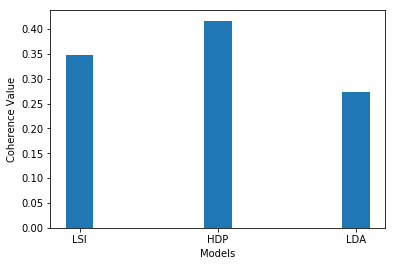

In [28]:
evaluate_bar_graph([lsi_coherence, hdp_coherence, lda_coherence],
                   ['LSI', 'HDP', 'LDA'])

We can see that topic coherence helped us get past manually inspecting our topic models - we can now keep fine tuning our models and compare between them to see which has the best performance. 

This also brings us to the end of the runnable part of this tutorial - we will continue however by briefly going over two more Jupyter notebooks I have previously worked on - mainly, [Dynamic Topic Modelling](https://github.com/RaRe-Technologies/gensim/blob/develop/docs/notebooks/ldaseqmodel.ipynb) and [Document Word Coloring](https://github.com/RaRe-Technologies/gensim/blob/develop/docs/notebooks/topic_methods.ipynb).